# SEGMENTATION MODEL

## Prepare Library, Parameters, and Dependencies

In [69]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib
import os
from tqdm import tqdm

%matplotlib inline

In [70]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [72]:
# Set Parameters
SEG_DATASET_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/'
SEG_TEST_DATASET_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/'
SAVE_MODEL_PATH = '/content/drive/MyDrive/Skripsi/v_0.0.2/models/segmentation_model_1/'
TEST_PREDICT_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'

BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2
SHUFFLE_BUFFER_SIZE_SEG = 10000

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

## Model #1 (U-Net Vanilla w/ Grayscaling)

#### Load Dataset Path

In [73]:
# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])
print(len(mask_path))
print(mask_path[1])

1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg
1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg


#### Load and Grayscaling Dataset

In [74]:
# Load and Grayscale Mask Image
masks = []
for path in tqdm(mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    masks.append(mask)

# Load and Grayscale OG Image
images = []
for path in tqdm(image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)

100%|██████████| 1476/1476 [00:09<00:00, 154.92it/s]


#### Clear Outlier on Mask Dataset

In [75]:
# Clear Outlier
for mask in masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

#### Visualize Dataset

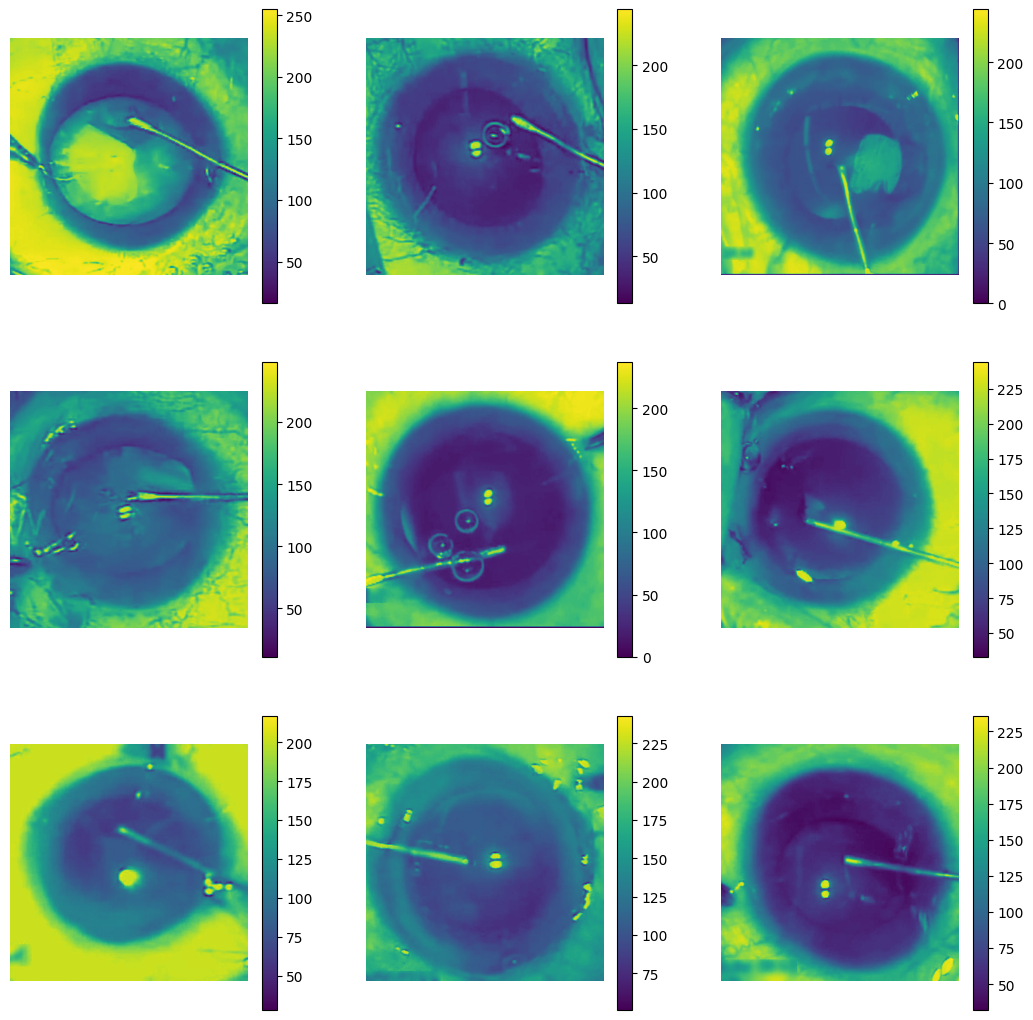

In [76]:
# Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

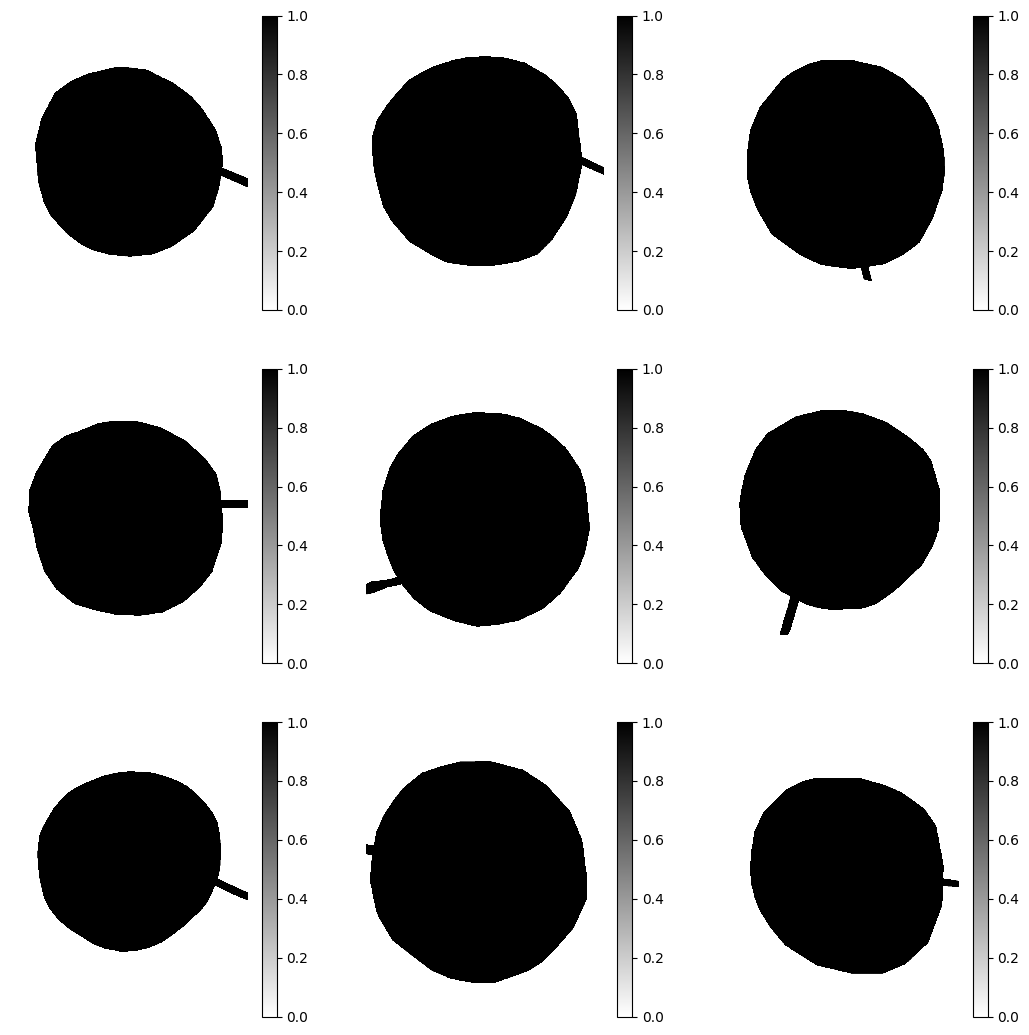

In [77]:
# Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

#### Resize Dataset

In [78]:
# Resize Function for Dataset OG Image
def resize_image(image):
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255
    return image

# Resize Function for Dataset Mask Image
def resize_mask(mask):
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask / 255
    mask = mask.astype(np.uint8)
    return mask

In [79]:
# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

In [80]:
print(X)

[array([[0.83529412, 0.85882353, 0.87058824, ..., 0.51372549, 0.49803922,
        0.49019608],
       [0.84705882, 0.87058824, 0.88627451, ..., 0.50980392, 0.49803922,
        0.49019608],
       [0.87058824, 0.87843137, 0.90196078, ..., 0.52156863, 0.52156863,
        0.50588235],
       ...,
       [0.56862745, 0.59215686, 0.50588235, ..., 0.65490196, 0.67058824,
        0.63137255],
       [0.5254902 , 0.81176471, 0.86666667, ..., 0.52941176, 0.44705882,
        0.38431373],
       [0.48235294, 0.46666667, 0.64313725, ..., 0.65882353, 0.64705882,
        0.61960784]]), array([[0.54901961, 0.54509804, 0.54117647, ..., 0.4745098 , 0.48627451,
        0.48627451],
       [0.55294118, 0.54509804, 0.52941176, ..., 0.4745098 , 0.48627451,
        0.48627451],
       [0.5372549 , 0.54901961, 0.56078431, ..., 0.46666667, 0.49019608,
        0.49019608],
       ...,
       [0.31372549, 0.3372549 , 0.44313725, ..., 0.49019608, 0.4627451 ,
        0.41960784],
       [0.42745098, 0.44705882, 0

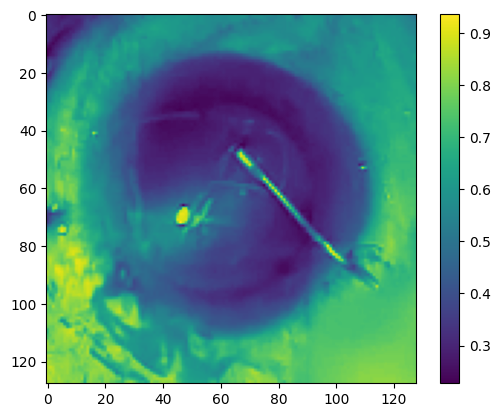

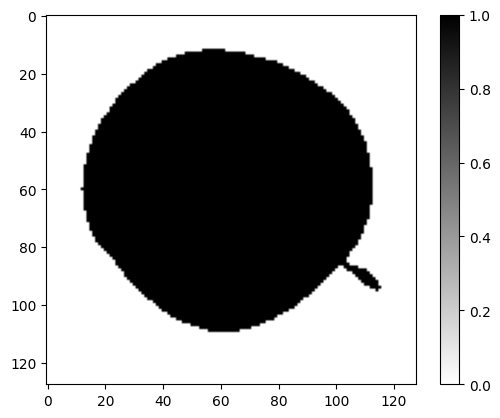

In [81]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

#### Split Dataset & Change Dataset Into TensorFlow Dataset

In [82]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

print(X_train)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

[array([[0.0627451 , 0.0627451 , 0.0627451 , ..., 0.82352941, 0.78431373,
        0.77647059],
       [0.0627451 , 0.0627451 , 0.0627451 , ..., 0.88235294, 0.84313725,
        0.82352941],
       [0.0627451 , 0.0627451 , 0.0627451 , ..., 0.90980392, 0.89803922,
        0.8745098 ],
       ...,
       [0.40392157, 0.41568627, 0.42352941, ..., 0.5372549 , 0.5372549 ,
        0.54901961],
       [0.40392157, 0.40392157, 0.41176471, ..., 0.52156863, 0.54117647,
        0.53333333],
       [0.4       , 0.41176471, 0.41960784, ..., 0.49411765, 0.50980392,
        0.53333333]]), array([[0.49019608, 0.49019608, 0.49411765, ..., 0.35686275, 0.36078431,
        0.36078431],
       [0.49411765, 0.49411765, 0.51764706, ..., 0.35686275, 0.36078431,
        0.36078431],
       [0.50980392, 0.50980392, 0.52156863, ..., 0.37254902, 0.38039216,
        0.39215686],
       ...,
       [0.91372549, 0.92156863, 0.92156863, ..., 0.22352941, 0.30196078,
        0.32941176],
       [0.91372549, 0.92156863, 0

(TensorSpec(shape=(128, 128), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None))

#### Dataset Augmentation

In [83]:
# Data Augmentation Function
def add_dimensional(image, mask):
    image = tf.expand_dims(image, -1)
    mask = tf.expand_dims(mask, -1)
    return image, mask

def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [84]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

In [85]:
# Check Train Count
print(len(train))

1180


In [86]:
# Perform Data Augmentation
train = train.map(add_dimensional)
au_brightness = train.map(brightness)
au_gamma = train.map(gamma)
au_flip_hori = train.map(flip_hori)
au_flip_vert = train.map(flip_vert)
au_rotate = train.map(rotate)

train = train.concatenate(au_brightness)
train = train.concatenate(au_gamma)
train = train.concatenate(au_flip_hori)
train = train.concatenate(au_flip_vert)
train = train.concatenate(au_rotate)

In [87]:
# Check Train Count after Augmentation
print(len(train))

7080


#### Dataset Pipelining

In [88]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE_SEG).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

#### Callbacks

In [89]:
# Checkpoint
checkpoint_path = 'model/my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

#### Model Architecture

In [90]:
# Encoder Block for Contracting Path in U-Net Architecture
def EncoderBlock(input_layer, n_filter, kernel_size=(3,3), kernel_initializer='he_normal', dropout_prob=0.1, max_pooling=True):
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x

    skip_connection = x

    return next_layer, skip_connection

# Decoder Block for Expansive Path in U-Net Architecture
def DecoderBlock(input_layer, skip_layer, n_filter, kernel_size=(2,2), kernel_initializer='he_normal', dropout_prob=0.1):
    x = keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=(2,2), padding='same')(input_layer)
    x = keras.layers.concatenate([x, skip_layer])
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    next_layer = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    return next_layer

In [91]:
# Input Layer
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name="input_image")

# Build Contraction Path
c1, s1 = EncoderBlock(input_layer, 16)
c2, s2 = EncoderBlock(c1, 32)
c3, s3 = EncoderBlock(c2, 64)
c4, s4 = EncoderBlock(c3, 128)
c5, _ = EncoderBlock(c4, 256, max_pooling=False)

# Build Expansive Path
e1 = DecoderBlock(c5, s4, 128)
e2 = DecoderBlock(e1, s3, 64)
e3 = DecoderBlock(e2, s2, 32)
e4 = DecoderBlock(e3, s1, 16)

# Output Layer
output = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(e4)

# Initialize Model
unet = keras.Model(inputs=[input_layer], outputs=[output])

In [92]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 128, 128, 16)         160       ['input_image[0][0]']         
                                                                                                  
 dropout_45 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_95[0][0]']           
                                                                                                  
 conv2d_96 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_45[0][0]']          
                                                                                            

#### Train Model

In [93]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [94]:
model_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=len(X_train) // BATCH_SIZE_SEG,
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=100,
    verbose=2,
    callbacks=[checkpoint]
)

unet.load_weights(checkpoint_path)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.22754, saving model to model/my_checkpoint.ckpt
147/147 - 14s - loss: 0.4098 - accuracy: 0.7943 - val_loss: 0.2275 - val_accuracy: 0.9039 - 14s/epoch - 93ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.22754 to 0.14314, saving model to model/my_checkpoint.ckpt
147/147 - 4s - loss: 0.1966 - accuracy: 0.9232 - val_loss: 0.1431 - val_accuracy: 0.9462 - 4s/epoch - 28ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.14314 to 0.12517, saving model to model/my_checkpoint.ckpt
147/147 - 4s - loss: 0.1798 - accuracy: 0.9303 - val_loss: 0.1252 - val_accuracy: 0.9528 - 4s/epoch - 28ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.12517
147/147 - 4s - loss: 0.1400 - accuracy: 0.9438 - val_loss: 0.1280 - val_accuracy: 0.9540 - 4s/epoch - 26ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.12517 to 0.11327, saving model to model/my_checkpoint.ckpt
147/147 - 4s - loss: 0.1289 - accuracy: 0.9488 - val_loss: 0.1133 - va

#### Visualize Accuracy and Loss

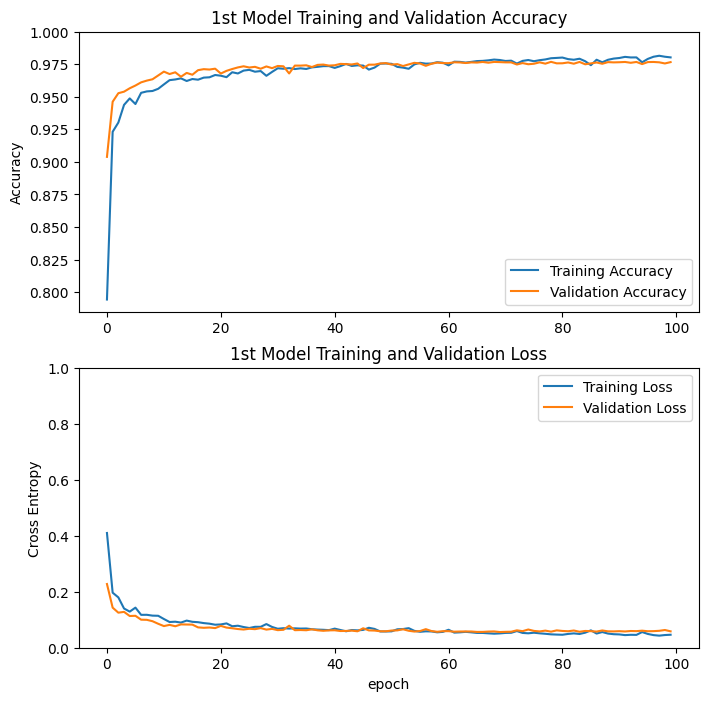

In [95]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate Model With Test Dataset

In [96]:
# Load Test Dataset OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(SEG_TEST_DATASET_DIR + 'test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(SEG_TEST_DATASET_DIR + 'test_mask/', file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append(image)

# Clear Outlier
for mask in test_masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

# Resize Test Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:01<00:00, 96.14it/s] 


In [97]:
# Evaluate Model
loss, accuracy = unet.evaluate(test)

17/17 [==============================] - 0s 11ms/step - loss: 0.0703 - accuracy: 0.9715


1/1 [==============================] - 0s 244ms/step


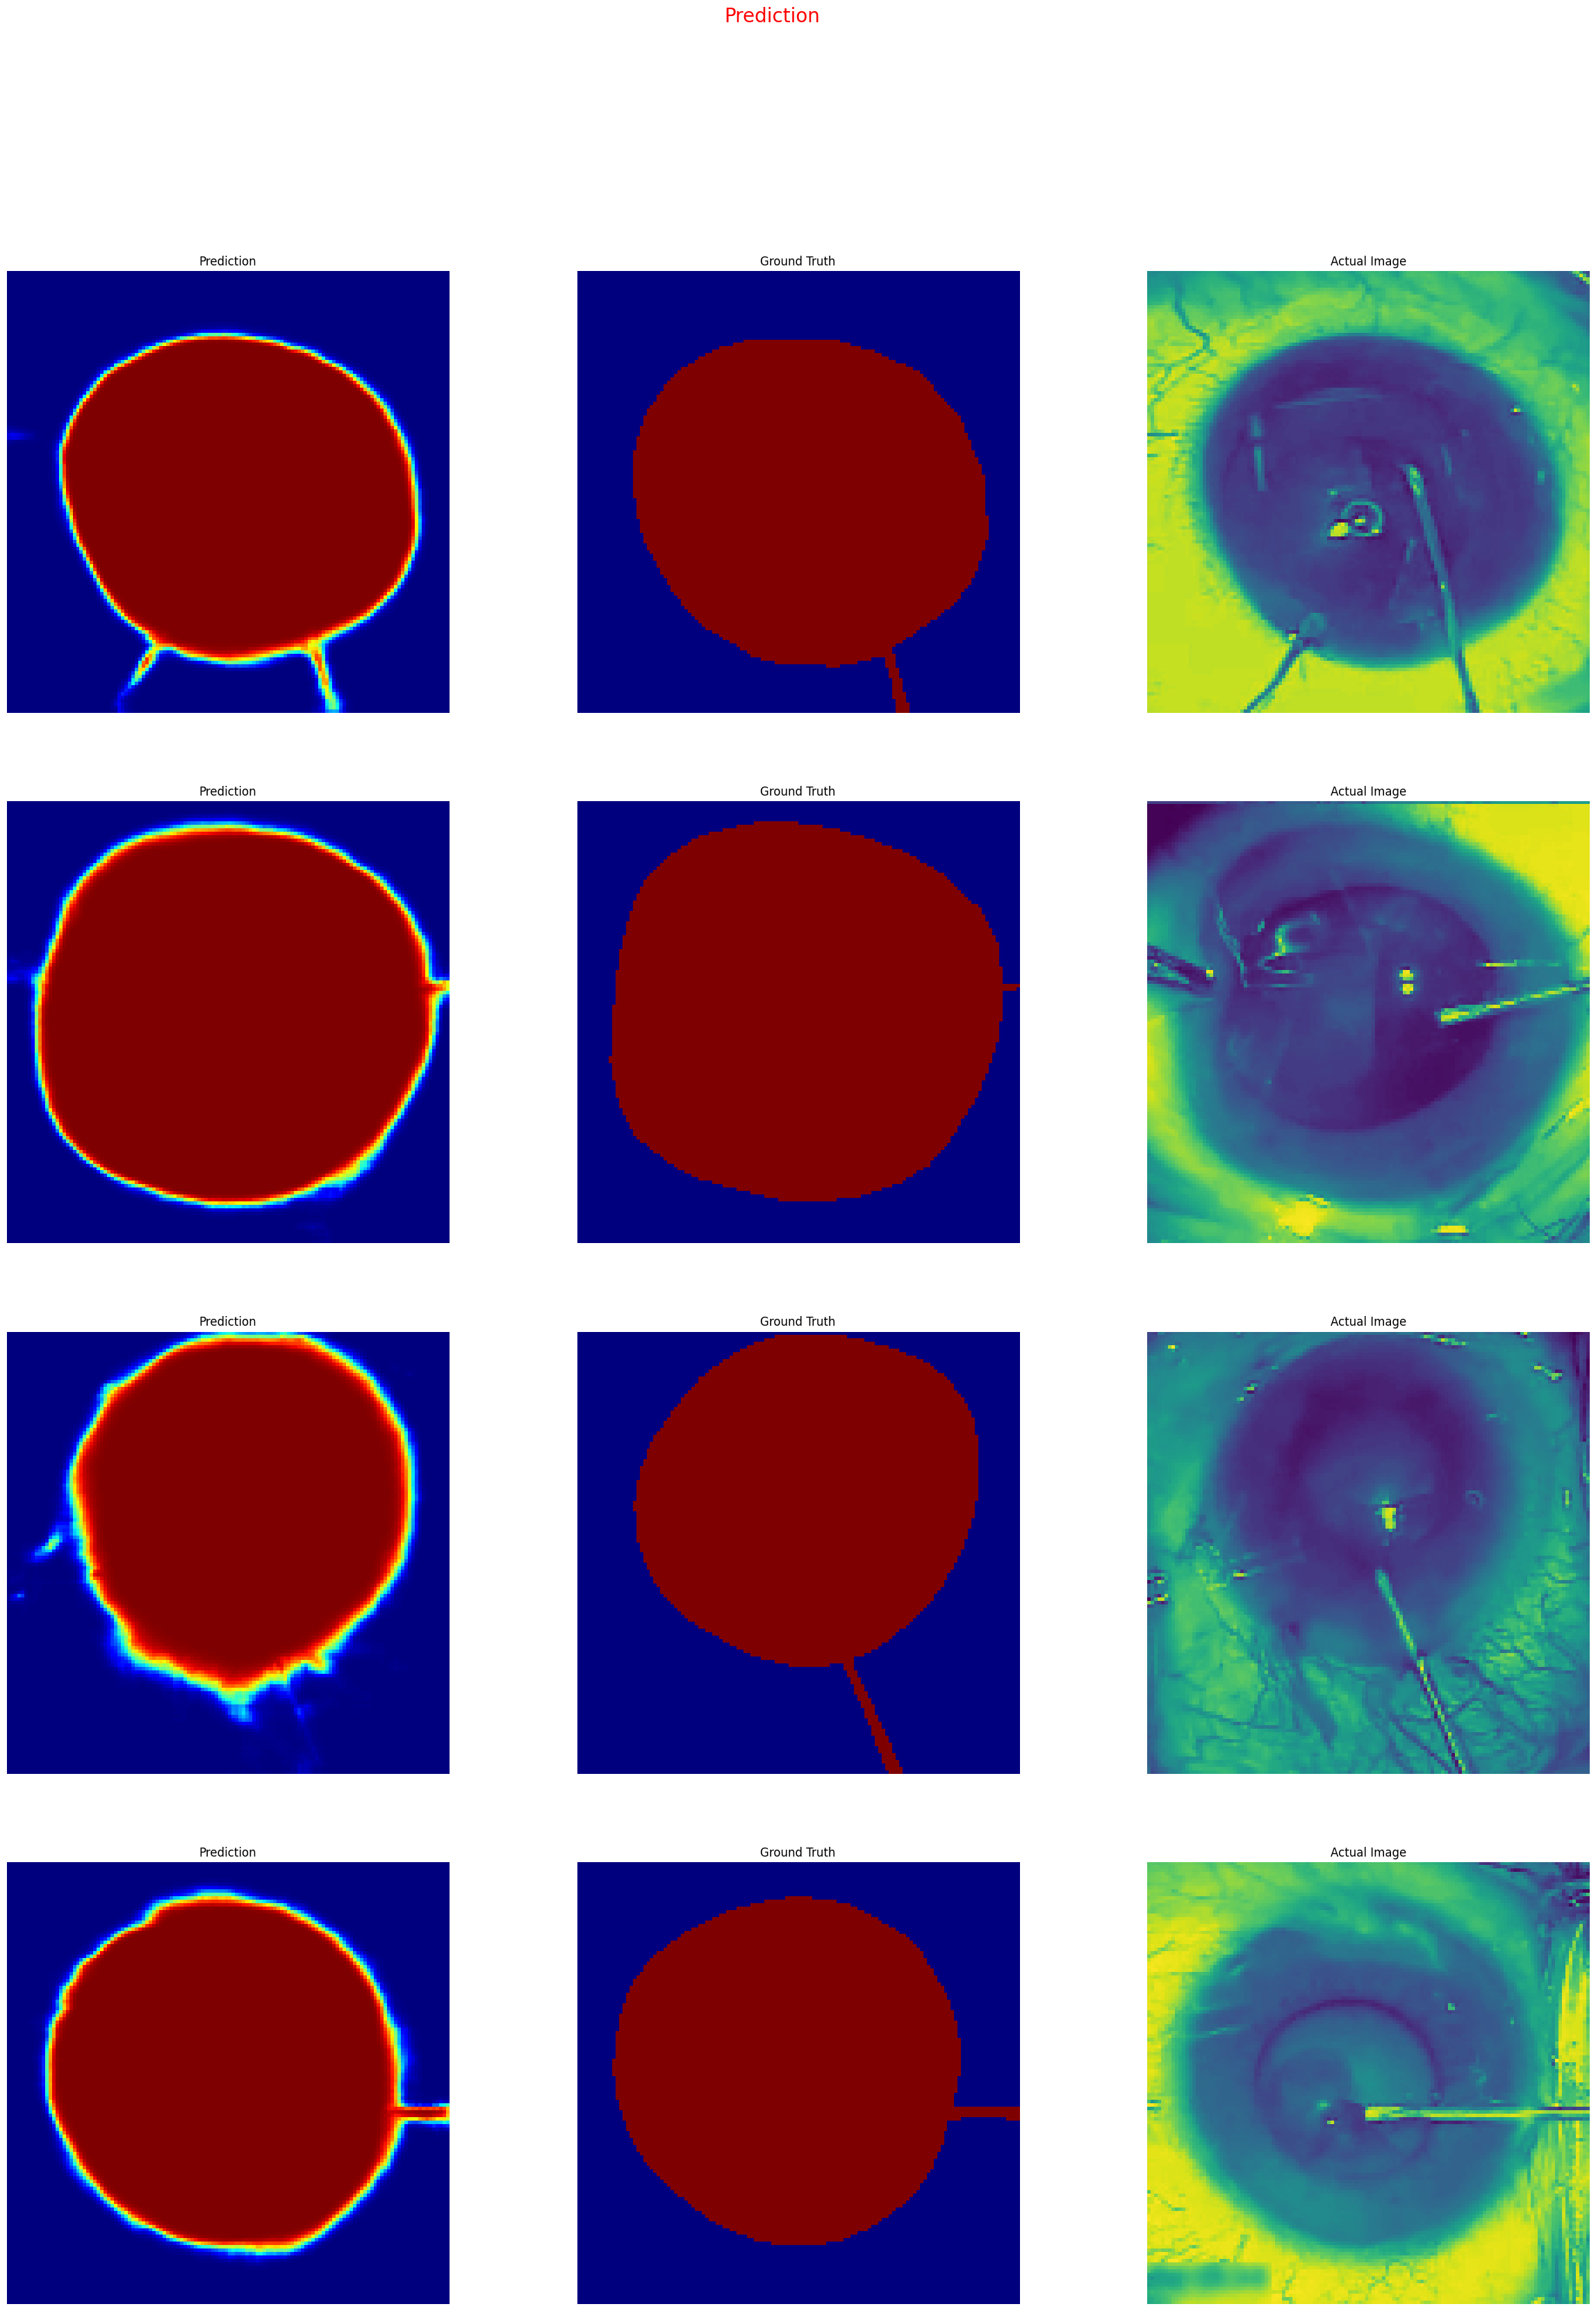

In [98]:
# Select a Test Data Batch
img, mask = next(iter(test))

# Make Prediction from Test Data Batch
pred = unet.predict(img)
plt.figure(figsize=(30,38))

for i in pred:
    i = i * 255

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    plt.imshow(i, cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

#### Test With Cataract Dataset

In [99]:
# Load Cataract OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(TEST_PREDICT_DIR):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(TEST_PREDICT_DIR,file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append(image)

# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

6
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg
6
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg


100%|██████████| 6/6 [00:00<00:00, 99.03it/s]


1/1 [==============================] - 0s 19ms/step


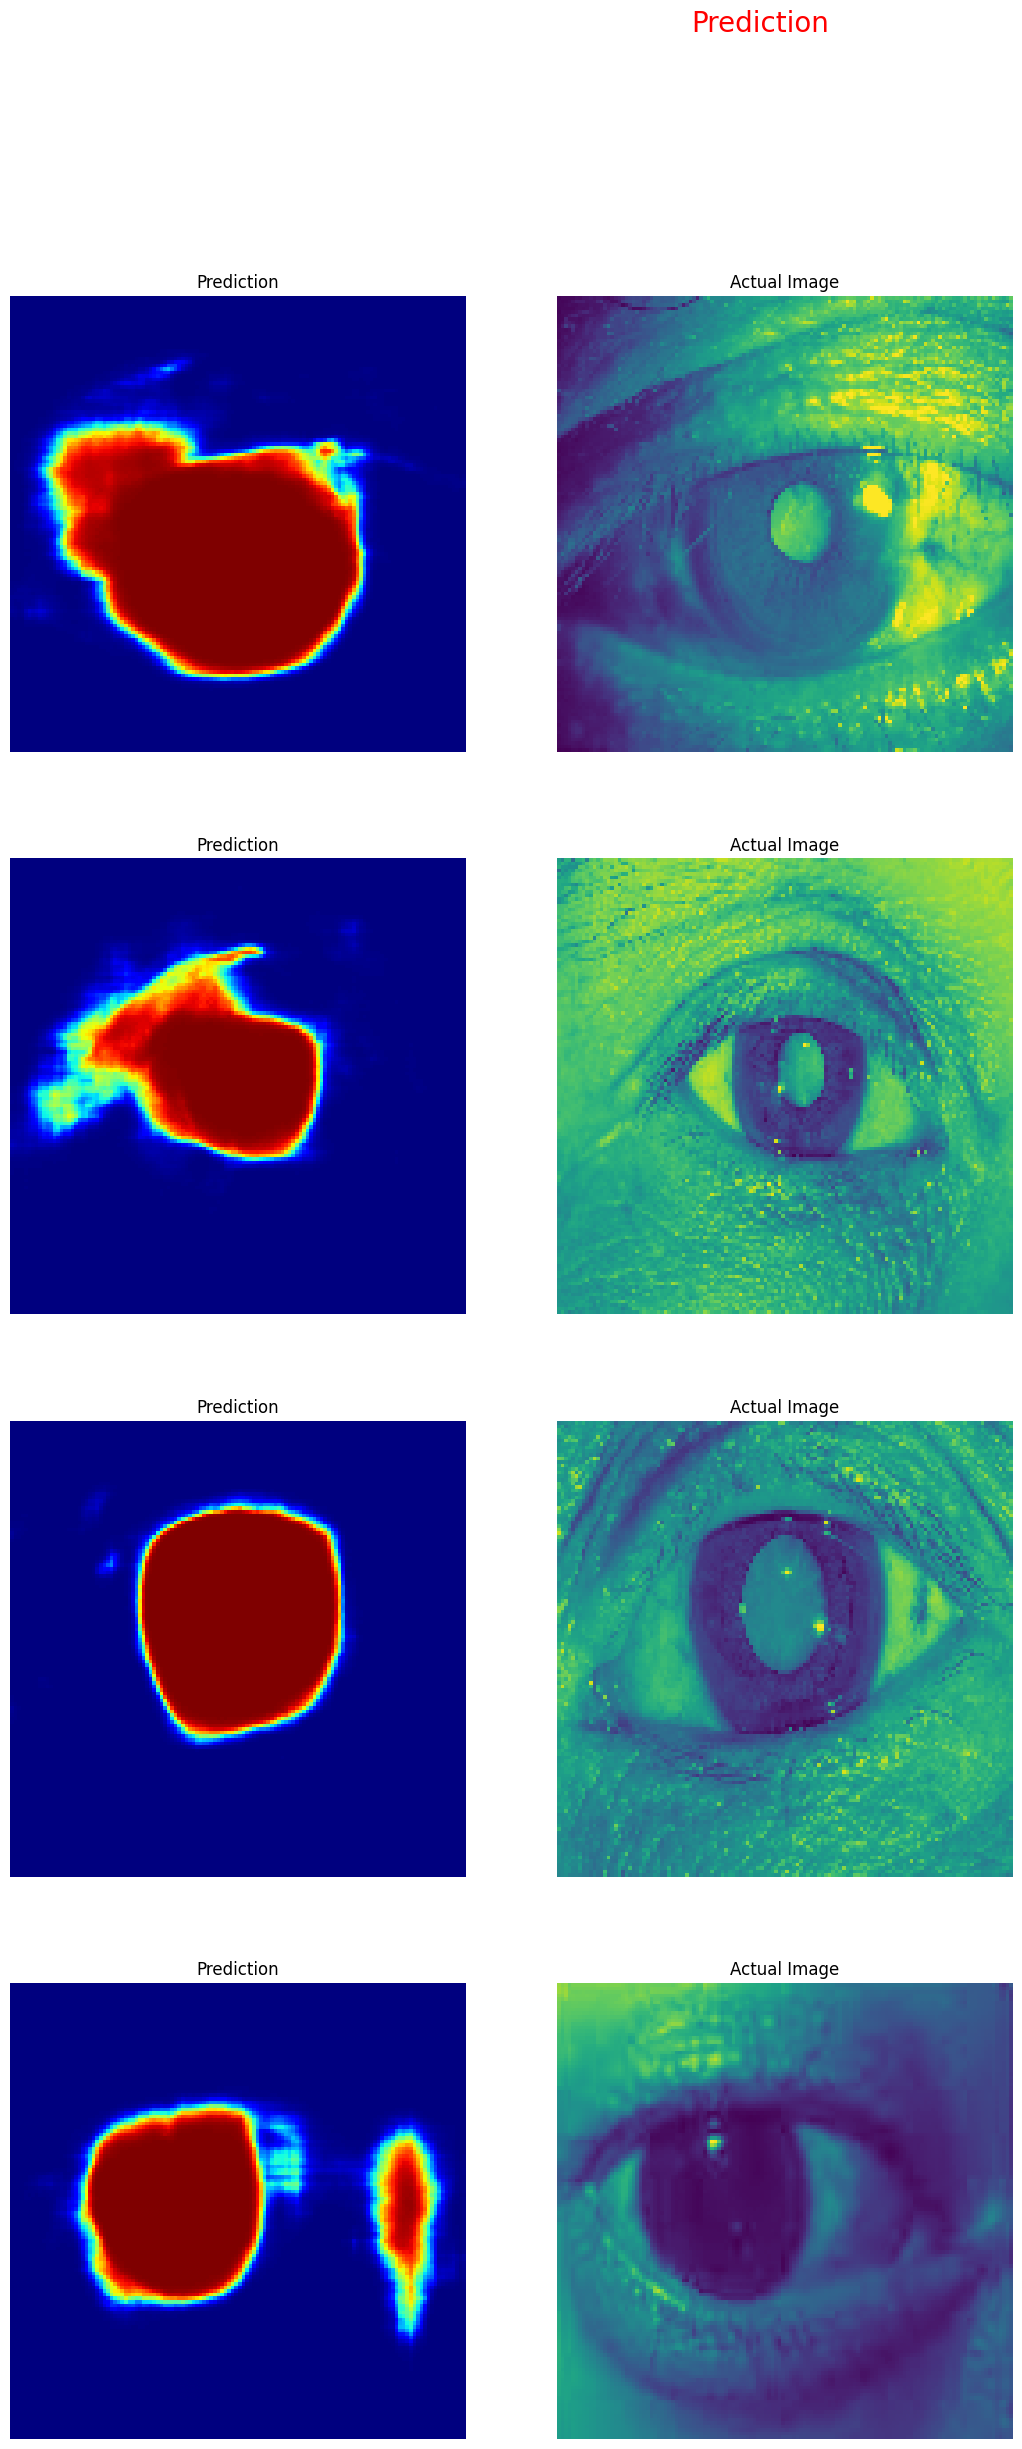

In [100]:
# Select a Cataract Test Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,2+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

## Save Model with TensorFlow Lite Converter

In [101]:
# Export Model to SavedModel Format
tf.saved_model.save(unet, SAVE_MODEL_PATH)

# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_MODEL_PATH)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the Model
tflite_model_file = pathlib.Path(SAVE_MODEL_PATH + 'model.tflite')
tflite_model_file.write_bytes(tflite_model)

6474208